# Modules

In [4]:
%load_ext autoreload
%autoreload 2

import sys

import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.optim import Adam
from torch.utils.data import DataLoader

sys.path.append("../")

from scarf.loss import NTXent
from scarf.model import SCARF

from example.dataset import ExampleDataset
from example.utils import dataset_embeddings, fix_seed, train_epoch

seed = 1234
fix_seed(seed)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

In [6]:
data = datasets.load_breast_cancer(as_frame=True)
data, target = data["data"], data["target"]
train_data, test_data, train_target, test_target = train_test_split(
    data, 
    target, 
    test_size=0.2, 
    stratify=target, 
    random_state=seed
)

# preprocess
constant_cols = [c for c in train_data.columns if train_data[c].nunique() == 1]
train_data.drop(columns=constant_cols, inplace=True)
test_data.drop(columns=constant_cols, inplace=True)

scaler = StandardScaler()
train_data = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns)
test_data = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns)

# to torch dataset
train_ds = ExampleDataset(
    train_data.to_numpy(), 
    train_target.to_numpy(), 
    columns=train_data.columns
)
test_ds = ExampleDataset(
    test_data.to_numpy(), 
    test_data.to_numpy(), 
    columns=test_data.columns
)

print(f"Train set: {train_ds.shape}")
print(f"Test set: {test_ds.shape}")
train_ds.to_dataframe().head()

Train set: (455, 30)
Test set: (114, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,-0.880353,-1.008502,-0.851600,-0.803450,0.528820,-0.257291,-0.443192,-0.407671,-0.129007,0.896290,...,-0.912743,-0.956058,-0.829103,-0.782999,0.427404,-0.216693,-0.214409,-0.123639,0.672669,0.366357
1,0.248449,1.482635,0.225824,0.152201,0.462742,-0.130230,0.414654,0.411382,-0.597113,0.266727,...,0.448496,1.198785,0.395258,0.279837,1.500623,-0.122839,0.611302,0.570670,-0.405498,0.563031
2,-1.345070,0.549036,-1.334836,-1.089839,0.609582,-0.812806,-0.856507,-0.939086,0.774546,0.461423,...,-1.133763,0.878470,-1.154989,-0.923432,0.906361,-0.870453,-1.018594,-1.198201,-0.042221,-0.059954
3,-0.139050,-0.389184,-0.190352,-0.253539,0.249823,-0.472841,-0.547939,-0.453825,-0.288671,-0.267620,...,-0.284796,-0.368815,-0.355786,-0.353509,-0.543816,-0.772100,-0.480259,-0.381195,-0.632129,-0.798305
4,1.054334,0.158496,0.884228,0.892295,-0.886724,-0.706354,-0.209267,0.167349,1.151934,-1.778288,...,0.876078,0.326818,0.631622,0.647473,-1.107034,-0.864668,-0.238274,0.045704,3.307260,-1.264719


# Training

In [50]:
batch_size = 128
epochs = 10_000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

model = SCARF(
    input_dim=train_ds.shape[1], 
    emb_dim=16,
    corruption_rate=0.6,
).to(device)
optimizer = Adam(model.parameters(), lr=0.001)
ntxent_loss = NTXent()

loss_history = []

for epoch in range(1, epochs + 1):
    epoch_loss = train_epoch(model, ntxent_loss, train_loader, optimizer, device, epoch)
    loss_history.append(epoch_loss)


Text(0, 0.5, 'loss')

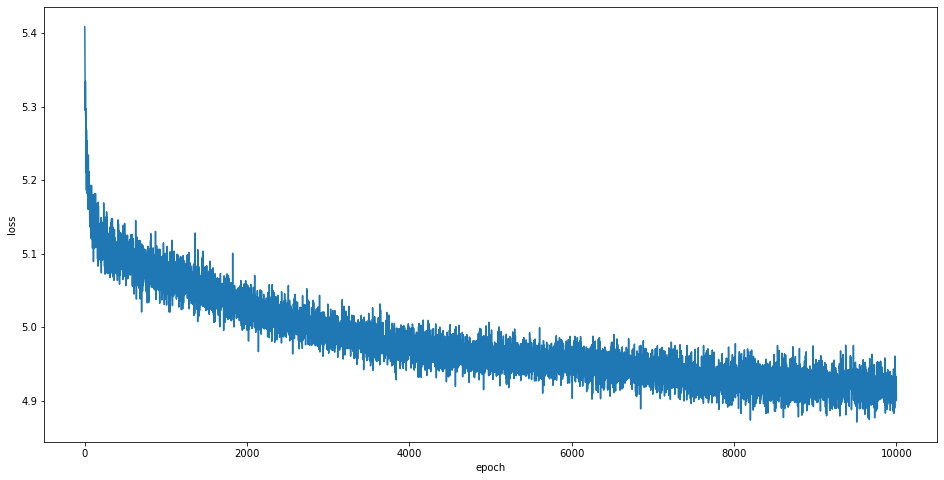

In [51]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(loss_history)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")

# Evaluate embeddings

In [52]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# get embeddings for training and test set
train_embeddings = dataset_embeddings(model, train_loader, device)
test_embeddings = dataset_embeddings(model, test_loader, device)

print(train_embeddings.shape)
print(test_embeddings.shape)

100%|██████████| 1/1 [00:00<00:00, 211.23it/s]

(455, 16)
(114, 16)


              precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



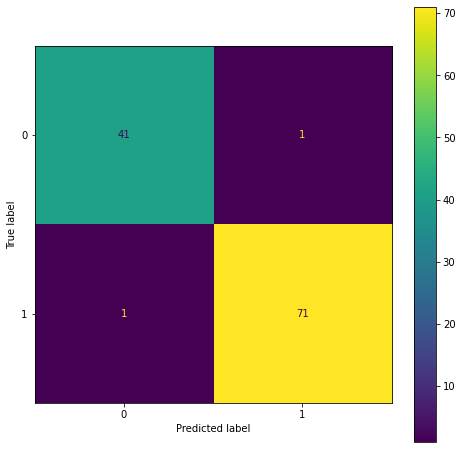

In [53]:
clf = LogisticRegression()

# vanilla dataset: train the classifier on the original data
clf.fit(train_data, train_target)
vanilla_predictions = clf.predict(test_data)

print(classification_report(test_target, vanilla_predictions))
cm = confusion_matrix(test_target, vanilla_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax)

              precision    recall  f1-score   support

           0       0.97      0.93      0.95        42
           1       0.96      0.99      0.97        72

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



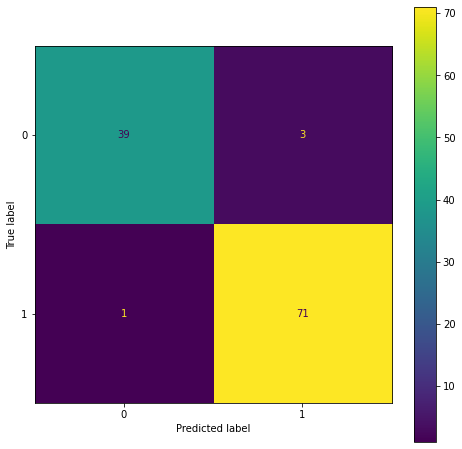

In [54]:
# embeddings dataset: train the classifier on the embeddings
clf.fit(train_embeddings, train_target)
vanilla_predictions = clf.predict(test_embeddings)

print(classification_report(test_target, vanilla_predictions))
cm = confusion_matrix(test_target, vanilla_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax)

# Visualzie using t-sne 

/usr/local/Caskroom/mambaforge/base/envs/scarf/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


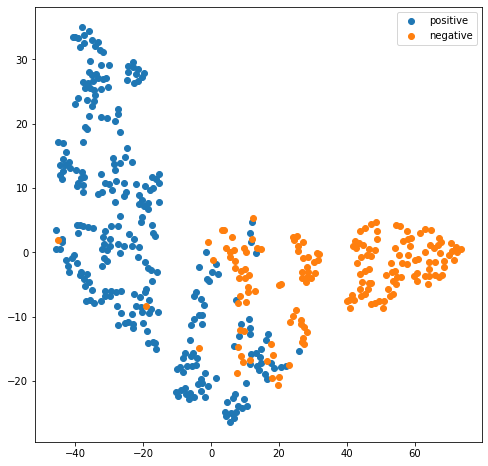

In [60]:
tsne = TSNE(n_components=2, learning_rate="auto", init="pca", perplexity=15)
reduced = tsne.fit_transform(train_embeddings)
positive = train_target == 1

fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(reduced[positive, 0], reduced[positive, 1], label="positive")
ax.scatter(reduced[~positive, 0], reduced[~positive, 1], label="negative")
plt.legend()